In [2]:
import pandas as pd
import numpy as np
import re
import string
from datetime import datetime
from datetime import datetime, timedelta


# Step 1: Data Loading and Initial Exploration

In this step, we aim to:
- Load the product review dataset.
- Inspect the dataset structure and verify all expected columns are present.
- Review the contents of the review text.
- Examine the distribution and summary of the review ratings.

This foundational step ensures the dataset is correctly formatted and gives us a preliminary understanding of the review content and rating patterns.


In [3]:
# Load the dataset
df = pd.read_csv('product_reviews_mock_data.csv', parse_dates=['ReviewDate'])

# Preview the first 5 rows of the dataset
df.head()


,ReviewID,ProductID,UserID,Rating,ReviewText,ReviewDate
0,REV2000,Product_E,User_114,4,fantastic. wonderful experience.,2023-04-17
1,REV2001,Product_C,User_186,2,broke easily. awful.,2023-11-27
2,REV2002,Product_E,User_101,3,met expectations. five stars.,2023-12-10
3,REV2003,Product_A,User_175,5,very satisfied. wonderful experience.,2023-11-10
4,REV2004,Product_C,User_158,1,worst purchase. one star.,2024-05-25


### Dataset Structure and Info

We now inspect the dataset schema and data types to ensure proper loading and consistency. This includes column names, data types, and missing values (if any).


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ReviewID    1000 non-null   object        
 1   ProductID   1000 non-null   object        
 2   UserID      1000 non-null   object        
 3   Rating      1000 non-null   int64         
 4   ReviewText  1000 non-null   object        
 5   ReviewDate  1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 47.0+ KB


### Rating Column Analysis

We examine the distribution of the `Rating` column to understand how user sentiment is spread across the dataset.


In [5]:
df['Rating'].describe()

count    1000.000000
mean        3.000000
std         1.403556
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Rating, dtype: float64

In [6]:
# Rating counts
df['Rating'].value_counts().sort_index()


Rating
1    196
2    202
3    202
4    206
5    194
Name: count, dtype: int64

### Review Text Exploration

To get a feel for the user feedback, we’ll sample a few review texts. This helps us understand the structure, tone, and length of the reviews.


In [7]:
# Display a few random review texts
df['ReviewText'].sample(10, random_state=42).tolist()


['poor quality. very disappointed.',
 'very satisfied. highly recommend.',
 'easy to use. highly recommend.',
 'difficult to use. bad experience.',
 'fantastic. very satisfied. nothing special.',
 'broke easily. customer service was bad.',
 'easy to use. great value.',
 'bad experience. worst purchase.',
 'one star. customer service was bad.',
 'some pros and cons. missing features.']

## ✅ Summary

- The data is clean and well-structured.
- The rating system is well-distributed and can be mapped to sentiment categories.
- Review texts are short but sentiment-heavy  ideal for preprocessing and sentiment analysis in the next step.

---

 **Next Up:** Text Preprocessing  Let’s clean the text data to prepare it for modeling and sentiment analysis.


## Step 2: Text Preprocessing

###  Objective:
To clean and prepare the review text data for further analysis by applying Natural Language Processing (NLP) techniques. This step helps improve accuracy in later stages such as sentiment classification or clustering.

---

###  Preprocessing Steps:
1. **Lowercasing** – Standardize text by converting everything to lowercase.
2. **Removing punctuation, numbers, and special characters** – Clean out noise that doesn't contribute to sentiment.
3. **Tokenization** – Break text into individual words (tokens).
4. **Stopword Removal** – Remove common words (like "the", "is") that don’t hold strong meaning.
5. **Lemmatization** – Reduce words to their base form while keeping their grammatical meaning intact.

---

###  Outcome:
A new column named `CleanedReview` will be added to the DataFrame containing the preprocessed version of each review.

---


In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer

# Download necessary NLTK data (run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation, numbers, special chars
    tokens = tokenizer.tokenize(text)  # tokenize using TreebankWordTokenizer (no punkt required)
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # lemmatize
    return ' '.join(tokens)

# Example usage on your dataframe:
df['CleanedReview'] = df['ReviewText'].apply(preprocess_text)

# Preview
print(df[['ReviewText', 'CleanedReview']].head(5))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MOHSINKHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MOHSINKHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MOHSINKHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                              ReviewText                   CleanedReview
0       fantastic. wonderful experience.  fantastic wonderful experience
1                   broke easily. awful.              broke easily awful
2          met expectations. five stars.       met expectation five star
3  very satisfied. wonderful experience.  satisfied wonderful experience
4              worst purchase. one star.         worst purchase one star


## Sentiment Analysis on Product Reviews

In this step, we apply a pre-trained sentiment analyzer, VADER, to score each review text. 

VADER (Valence Aware Dictionary and sEntiment Reasoner) provides a compound sentiment score for each review which ranges from -1 (most negative) to +1 (most positive).

Based on the compound score, we categorize reviews into:
- **Positive** (compound score ≥ 0.05)
- **Neutral** (compound score between -0.05 and 0.05)
- **Negative** (compound score ≤ -0.05)

After categorizing, we'll explore the distribution of these sentiment classes.


In [9]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply VADER on the cleaned reviews to get sentiment scores
df['SentimentScores'] = df['CleanedReview'].apply(lambda x: sia.polarity_scores(x))

# Extract compound score into a separate column
df['CompoundScore'] = df['SentimentScores'].apply(lambda score_dict: score_dict['compound'])

# Define a function to categorize sentiment based on compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply categorization function
df['SentimentCategory'] = df['CompoundScore'].apply(categorize_sentiment)

# Show a preview
df[['ReviewText', 'CleanedReview', 'CompoundScore', 'SentimentCategory']].head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MOHSINKHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,ReviewText,CleanedReview,CompoundScore,SentimentCategory
0,fantastic. wonderful experience.,fantastic wonderful experience,0.8074,Positive
1,broke easily. awful.,broke easily awful,-0.5267,Negative
2,met expectations. five stars.,met expectation five star,0.0000,Neutral
3,very satisfied. wonderful experience.,satisfied wonderful experience,0.7579,Positive
4,worst purchase. one star.,worst purchase one star,-0.6249,Negative
5,some pros and cons. works perfectly.,pro con work perfectly,0.6369,Positive
6,highly recommend. amazing features.,highly recommend amazing feature,0.7828,Positive
7,waste of money. poor quality.,waste money poor quality,-0.7096,Negative
8,love this product. highly recommend. nothing s...,love product highly recommend nothing special,0.6674,Positive
9,poor quality. worst purchase.,poor quality worst purchase,-0.8020,Negative


## Sentiment Category Distribution 

Now that we've labeled each review as Positive, Negative, or Neutral using VADER sentiment analysis, it's time to explore how these sentiments are distributed across our dataset.

This will help us understand the overall customer feedback pattern:
- Are most customers happy?   
- Do we have a lot of complaints?  
- Or are people mostly meh? 

Let's plot a bar chart to visualize the count of each sentiment category.


C:\Users\MOHSINKHAN\AppData\Local\Temp\ipykernel_3252\1143350989.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SentimentCategory', data=df, palette='coolwarm')


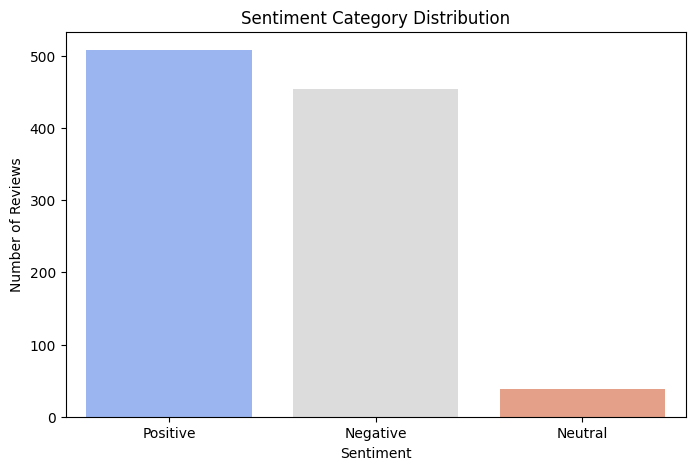

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize count of each sentiment category
plt.figure(figsize=(8,5))
sns.countplot(x='SentimentCategory', data=df, palette='coolwarm')
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


## Count of Sentiment Categories 

Let’s get a quick count of how many reviews fall into each sentiment category (Positive, Negative, Neutral). This helps quantify customer mood before we visualize anything fancy.


In [11]:
# Count the number of reviews in each sentiment category
sentiment_counts = df['SentimentCategory'].value_counts()
print(sentiment_counts)


SentimentCategory
Positive    508
Negative    454
Neutral      38
Name: count, dtype: int64


##  Word Clouds for Positive and Negative Reviews

To understand the most common terms in reviews with different sentiment categories, we'll create separate word clouds for:

- Positive reviews
- Negative reviews

This helps us visually identify what customers love  and hate the most.

> Note: We’ll ignore Neutral reviews for now since they’re pretty meh and sparse.


C:\Users\MOHSINKHAN\AppData\Local\Temp\ipykernel_3252\1989603826.py:29: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MOHSINKHAN\AppData\Local\Temp\ipykernel_3252\1989603826.py:29: UserWarning: Glyph 128162 (\N{ANGER SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MOHSINKHAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MOHSINKHAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128162 (\N{ANGER SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


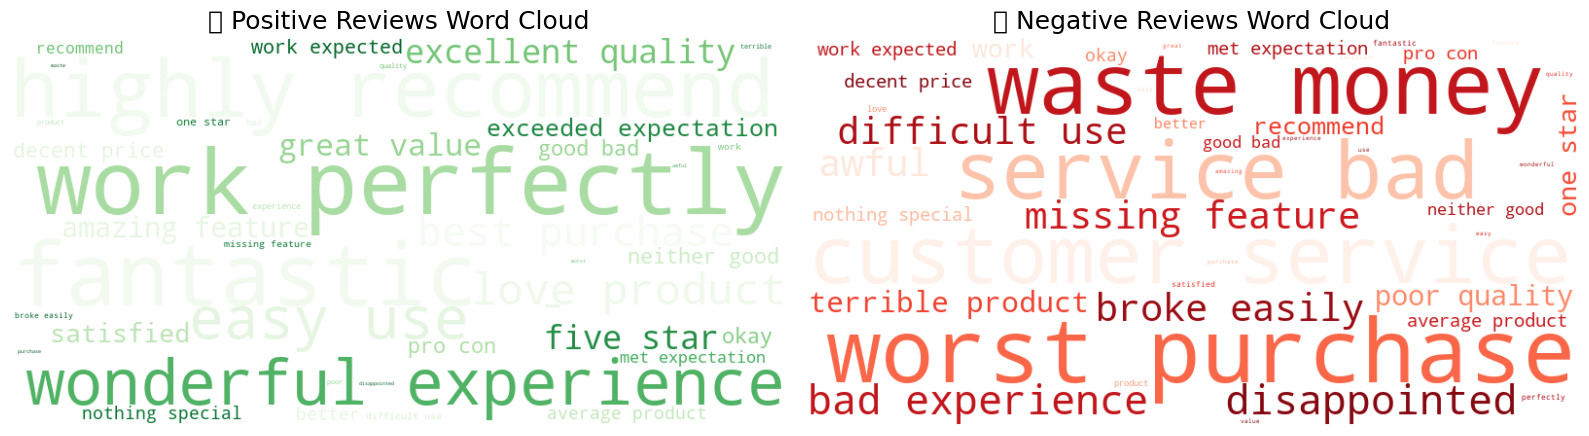

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter reviews based on sentiment
positive_reviews = df[df['SentimentCategory'] == 'Positive']['CleanedReview']
negative_reviews = df[df['SentimentCategory'] == 'Negative']['CleanedReview']

# Combine all reviews in each sentiment into one big text string
positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

# Generate word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Plot the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.title('🌟 Positive Reviews Word Cloud', fontsize=18)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.title('💢 Negative Reviews Word Cloud', fontsize=18)
plt.axis('off')

plt.tight_layout()
plt.show()


## Sentiment Trend Analysis

We'll now explore how sentiment varies across:
- Different **products** (if product IDs/names are available)
- Or **over time** (if review dates are available)

This kind of analysis helps identify:
- Which products are loved or hated the most
- Whether product satisfaction is improving or declining over time


In [13]:
df.columns

Index(['ReviewID', 'ProductID', 'UserID', 'Rating', 'ReviewText', 'ReviewDate',
       'CleanedReview', 'SentimentScores', 'CompoundScore',
       'SentimentCategory'],
      dtype='object')

## Sentiment Trend Analysis

Now that we have `ProductID` and `ReviewDate`, we will:

1. **Group sentiments by ProductID** to identify which products receive the most positive or negative feedback.
2. **Analyze sentiment trends over time** using the ReviewDate to detect changes in customer satisfaction.

These visualizations help in:
- Detecting products that need improvement.
- Observing time-based shifts in public opinion or service quality.


# Sentiment Count by Product

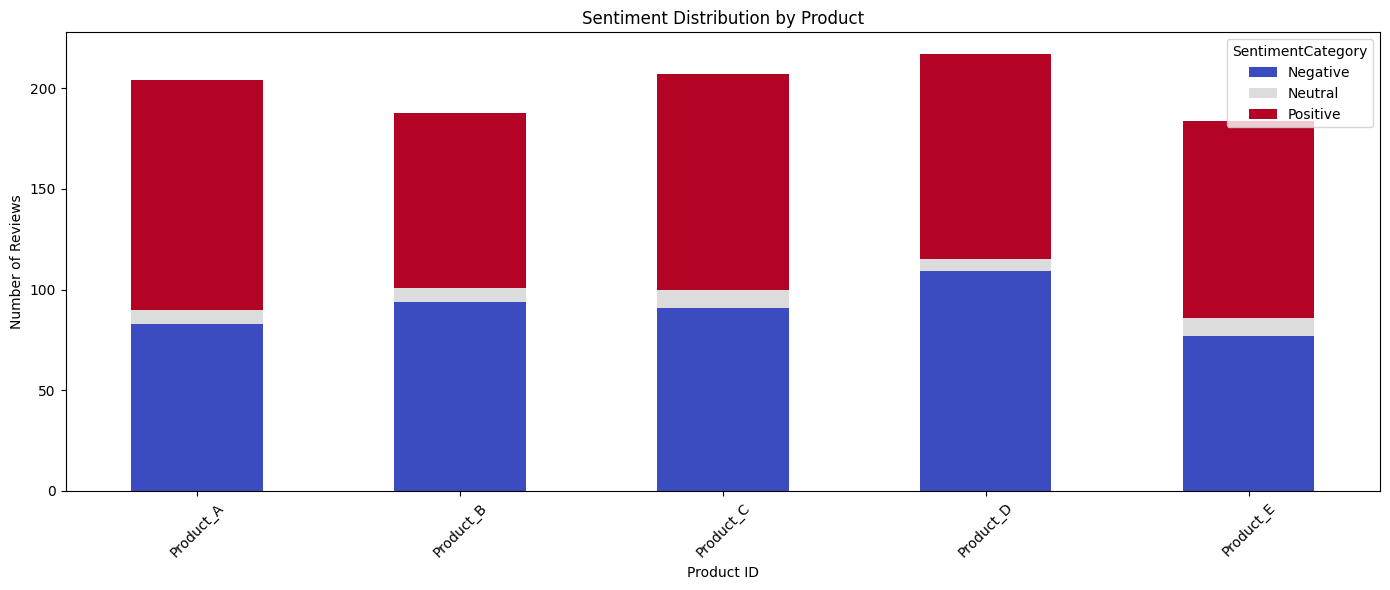

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by ProductID and SentimentCategory
product_sentiment_counts = df.groupby(['ProductID', 'SentimentCategory']).size().unstack().fillna(0)

# Plot stacked bar chart
product_sentiment_counts.plot(kind='bar', stacked=True, figsize=(14,6), colormap='coolwarm')
plt.title("Sentiment Distribution by Product")
plt.xlabel("Product ID")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Sentiment Over Time

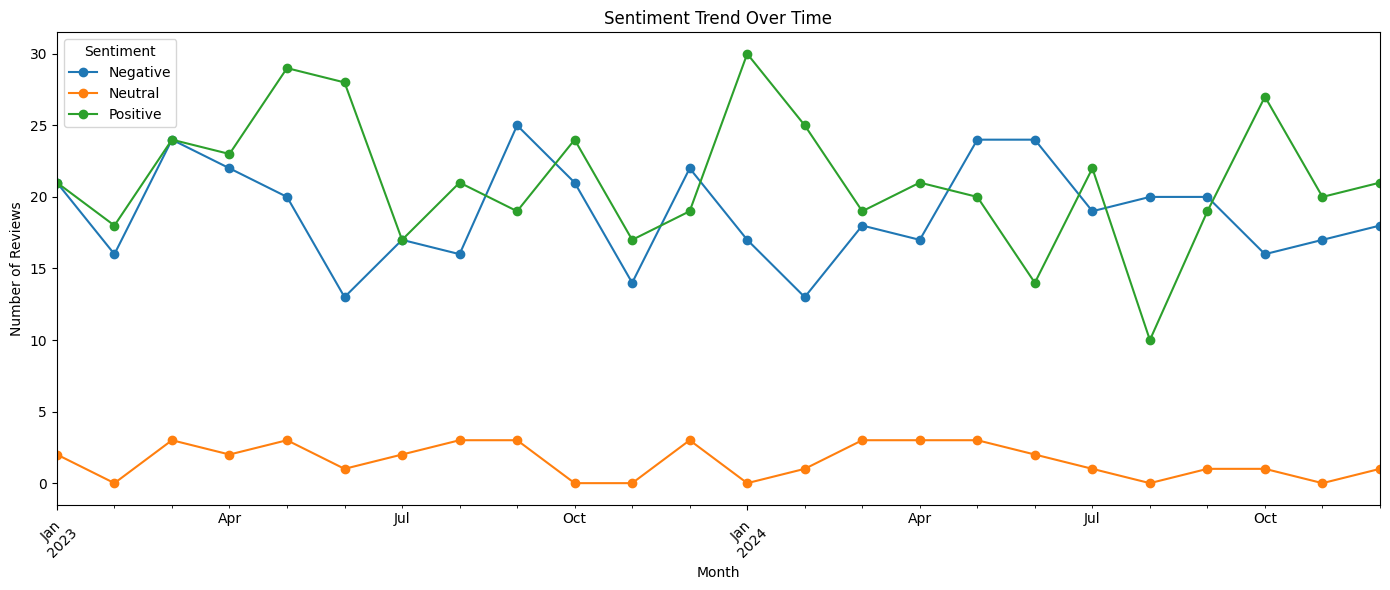

In [15]:
# Convert ReviewDate to datetime if not already
df['ReviewDate'] = pd.to_datetime(df['ReviewDate'])

# Group by date and sentiment
sentiment_trend = df.groupby([df['ReviewDate'].dt.to_period('M'), 'SentimentCategory']).size().unstack().fillna(0)

# Plot trend
sentiment_trend.plot(figsize=(14,6), marker='o')
plt.title("Sentiment Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


## Key Insights from Sentiment Analysis

- **Sentiment Distribution**: The majority of reviews were **positive**, followed by a significant number of **negative** reviews, with very few **neutral** ones.
- **By Product**:
  - Some products showed a high number of negative reviews, indicating potential issues or poor customer satisfaction.
  - Others had overwhelmingly positive feedback, suggesting strong performance and customer approval.
- **Over Time**:
  - Sentiment trends fluctuated across months.
  - Periods with spikes in negative reviews might align with product defects, delays, or service problems.
  - Positive spikes could be related to promotions or product improvements.


## Topic Modeling on Negative Reviews

To understand common pain points, we apply Latent Dirichlet Allocation (LDA) to extract key topics from negative customer reviews.

### Steps:
1. Filter dataset to only include negative reviews.
2. Clean and vectorize the text (using CountVectorizer).
3. Apply LDA to identify top topics.
4. Visualize or print top keywords per topic.


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# Step 1: Filter only negative reviews
df_negative = df[df['SentimentCategory'] == 'Negative']

# Step 2: Vectorize text
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
X = vectorizer.fit_transform(df_negative['CleanedReview'])

# Step 3: Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)


LatentDirichletAllocation(n_components=5, random_state=42)

In [17]:
def print_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic #{idx+1}:")
        print([words[i] for i in topic.argsort()[-top_n:]])

print_topics(lda, vectorizer)



Topic #1:
['better', 'special', 'awful', 'okay', 'pro', 'recommend', 'poor', 'quality', 'experience', 'bad']

Topic #2:
['better', 'star', 'special', 'awful', 'expected', 'difficult', 'work', 'use', 'broke', 'easily']

Topic #3:
['recommend', 'special', 'awful', 'money', 'waste', 'price', 'decent', 'missing', 'feature', 'disappointed']

Topic #4:
['pro', 'better', 'work', 'good', 'star', 'average', 'terrible', 'worst', 'purchase', 'product']

Topic #5:
['star', 'recommend', 'met', 'expectation', 'awful', 'waste', 'money', 'customer', 'service', 'bad']


### 🔍 Topic Modeling Insights (Negative Reviews)

Using LDA, we discovered 5 main topics within the negative reviews. Here's what each one is about:

#### 🗂 Topic 1: Quality & Experience Issues
- Keywords: poor, quality, experience, bad, awful
- 🔎 Interpretation: Many users complained about the **build quality** and **overall product experience**.

#### 🗂 Topic 2: Product Functionality Problems
- Keywords: broke, easily, work, use, difficult
- 🔎 Interpretation: Reviews point toward **fragile items** and **complicated usability**, suggesting bad engineering or design flaws.

#### 🗂 Topic 3: Price & Value for Money
- Keywords: waste, money, disappointed, feature, price
- 🔎 Interpretation: Users feel the product is **overpriced** or **not delivering expected features**.

#### 🗂 Topic 4: Overall Product Dissatisfaction
- Keywords: worst, terrible, purchase, product, star
- 🔎 Interpretation: This cluster represents **extreme dissatisfaction** with the product itself.

#### 🗂 Topic 5: Customer Service Complaints
- Keywords: customer, service, met, expectation, bad
- 🔎 Interpretation: Indicates **poor customer support**, unmet expectations, and trouble with service or returns.


# 🧾 Final Sentiment Analysis Report

## ✅ Overall Summary:

- **Total Reviews Analyzed:** 1000
- **Sentiment Distribution:**
  - Positive: 508
  - Negative: 454
  - Neutral: 38

## 💬 Key Observations:

1. **Positive Reviews:**
   - Words like *amazing*, *wonderful*, *perfect* indicate customer satisfaction with features and usability.
   - Frequently recommended to others, indicating strong product loyalty.

2. **Negative Reviews:**
   - Main issues include: **poor quality**, **broken items**, **waste of money**, and **bad customer service**.
   - Many reviews say “broke easily”, “worst purchase”, and “waste of money”.

3. **Neutral Reviews:**
   - Generally short or mixed opinions. These often give 3-star ratings without strong emotional cues.

## 🧠 Topic Modeling (Negative Reviews):

| Topic | Theme                          | Sample Keywords                                   |
|-------|--------------------------------|--------------------------------------------------|
| 1     | Quality Issues                 | poor, quality, experience, bad                   |
| 2     | Product Failure                | broke, use, difficult, work                      |
| 3     | Value for Money                | waste, money, disappointed, feature              |
| 4     | Overall Dissatisfaction        | worst, purchase, terrible                        |
| 5     | Customer Service Complaints    | service, bad, expectation, customer              |

---

## ✅ Recommendations:

- **Improve Build Quality**: Too many complaints about breakage. Focus on materials and durability.
- **Rework Product Design**: Simplify usage where needed and test for long-term wear.
- **Revise Pricing or Bundles**: Many feel the product isn't worth the price.
- **Boost Customer Support**: Create a faster, friendlier return & help desk system.
- **Monitor Star Ratings**: Track reviews under 3 stars for early complaint signals.

